**Install Libraries**

In [1]:
!pip install -q magnumnp numpy==1.23 ipympl tqdm
from google.colab import output
import torch
from magnumnp import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
output.enable_custom_widget_manager()
%matplotlib ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

2023-11-06 15:00:00  magnum.np:INFO magnum.np 1.1.3
INFO:magnum.np:magnum.np 1.1.3


**Run Time-Integration**

In [2]:
#@markdown Parameters (Time)
Nt = 500                       #@param {}
dt = 1e-12                     #@param {}

#@markdown Parameters (Space)
n = 500, 25, 1                 #@param {}
dx = 2e-9, 2e-9, 1e-9          #@param {}

#@markdown Parameters (Materials)
Ms = 8e5                       #@param {}
A = 1.3e-11                    #@param {}
alpha = 1e-8                   #@param {}

#@markdown Parameters (Fields)
h_bias   = [804e3, 0.0, 0.0]   #@param {}
h_excite = [0.0, 0.0, 400e3]   #@param {}



# define mesh
origin = (-n[0]*dx[0]/2, -n[1]*dx[1]/2, -n[2]*dx[2]/2)
mesh = Mesh(n, dx, origin)

# initialize state
state = State(mesh, dtype = torch.float32)
x,y,z = state.SpatialCoordinate()
mt = state.zeros((Nt, n[0], n[1], n[2]))

state.material = {
    'Ms': Ms,
    'A': A,
    'alpha': alpha
    }

state.m = state.Constant(h_bias)
state.m.normalize()

# initialize spin wave excitation field
N = n[0] / 2
kc = N/2. * (2.*torch.pi/(n[0]*dx[0]))
fc = 1/(2*dt)

h0 = state.Constant(h_excite)
h0 *= torch.special.sinc(kc / torch.pi * x).unsqueeze(-1)
h0 *= torch.special.sinc(kc / torch.pi * y).unsqueeze(-1)

omega = 2.*fc
t0 = 50e-12
ht = lambda t: torch.sinc(omega * (t-t0)) * h0

# initialize energy terms
demag    = DemagField()
exchange = ExchangeField()
bias     = ExternalField(state.Constant(h_bias))
excite   = ExternalField(ht)

# initialize LLG solver and relax state
set_log_level(100)
llg = LLGSolver([demag, exchange, bias])
llg.relax(state)

# apply spin wave excitation
state.t = 0.0
llg = LLGSolver([demag, exchange, bias, excite])

for i in tqdm(range(Nt)):
    mt[i,...] = state.m[...,2]
    llg.step(state, dt)

set_log_level(30)
torch.save(mt, "mt_saved.pt")

2023-11-06 15:00:00  magnum.np:INFO [State] running on device: cpu (dtype = float32)
INFO:magnum.np:[State] running on device: cpu (dtype = float32)
2023-11-06 15:00:00  magnum.np:INFO [Mesh] 500x25x1 (size= 2e-09 x 2e-09 x 1e-09)
INFO:magnum.np:[Mesh] 500x25x1 (size= 2e-09 x 2e-09 x 1e-09)
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


**Plot Results**

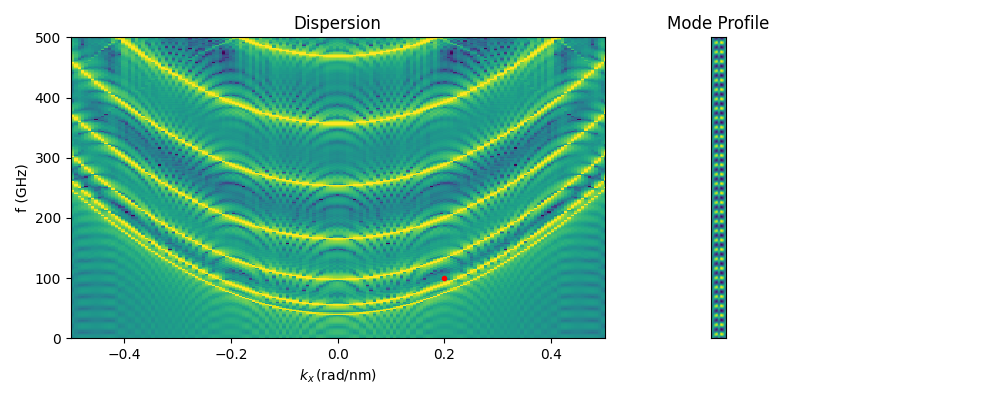

In [3]:
mt = mt.to(torch.device("cpu"))
k = 0.2
f = 100

# plot dispersion
mfft = torch.fft.fftn(mt, dim = (0,1))
ff = torch.fft.fftfreq(mfft.shape[0], dt)
kk = torch.fft.fftfreq(mfft.shape[1], dx[0])*2*torch.pi

disp = mfft[:,:,int(n[1]//2),0].abs()
cbmax_bv = 10.*np.log10(disp**2).max()
cbmin_bv = 10.*np.log10(disp**2).min()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 4])
ax1.set_title('Dispersion')
ax1.pcolormesh(torch.fft.fftshift(kk)/1e9, torch.fft.fftshift(ff)/1e9, 10.*np.log(torch.fft.fftshift(disp)**2.), vmin = cbmin_bv, vmax = cbmax_bv, cmap = "viridis", shading = "auto")
dot, = ax1.plot(k, f, 'r.')
ax1.set_xlabel(r'$k_{x}\,\mathrm{(rad/nm)}$', fontsize=10)
ax1.set_ylabel('f (GHz)', fontsize=10)
ax1.set_ylim([0, 500])
ax1.set_xlim([-0.5, 0.5])

# plot mode profile
def get_mi(f,k):
    # Determine ki and fi indizes
    fi = (ff-f*1e9).abs().argmin()
    ki = (kk-k*1e9).abs().argmin()

    mfft_i = torch.zeros_like(mfft[fi,...])
    mfft_i[ki,...] = mfft[fi,ki,...]
    mi = torch.fft.ifftn(mfft_i, dim = 0)
    return mi[:,:,0].real

mi = get_mi(f,k)
mi = mi / mi.max()

ax2.set_title('Mode Profile')
mode = ax2.imshow(mi)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

fig.canvas.header_visible = False
fig.canvas.footer_visible = False

def onclick(event):
    global k, f
    k, f = event.xdata, event.ydata
    dot.set_xdata((k,))
    dot.set_ydata((f,))
    mi = get_mi(f,k)
    mi = mi / mi.max()
    mode.set_data(mi)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

fig.tight_layout()
fig.savefig("result.png")